In [18]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

PROJECT_PATH = "/content/drive/MyDrive/ViT"
os.makedirs(PROJECT_PATH, exist_ok=True)
os.chdir(PROJECT_PATH)
sys.path.insert(0, PROJECT_PATH)

print(f"Working in: {PROJECT_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working in: /content/drive/MyDrive/ViT


In [2]:
!pip install torch torchvision einops matplotlib tqdm pillow
!pip install -U numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import einops
import time
from PIL import Image
import requests
from io import BytesIO
import os

In [24]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=32, patch_size=4, channels=3, dim=384):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.proj = nn.Conv2d(
            channels, dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        b, c, h, w = x.shape
        x = self.proj(x)
        x = einops.rearrange(x, 'b c h w -> b (h w) c')
        cls_tokens = einops.repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        return self.dropout(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.0):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.last_attn = None

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: einops.rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)
        attn = self.dropout(attn)
        self.last_attn = attn.detach()
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = einops.rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_dim, dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, image_size=32, patch_size=4, num_classes=10, dim=384,
                 depth=6, heads=8, mlp_dim=1024, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(
            image_size=image_size,
            patch_size=patch_size,
            channels=3,
            dim=dim
        )
        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim=dim,
                heads=heads,
                mlp_dim=mlp_dim,
                dropout=dropout
            ) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)
        self.attention_weights = []

    def forward(self, x):
        x = self.patch_embed(x)
        for block in self.blocks:
            x = block(x)
        cls_token = x[:, 0]
        cls_token = self.norm(cls_token)
        return self.head(cls_token)

def get_attention(self, x):
    self.attention_weights = []
    x = self.patch_embed(x)
    for block in self.blocks:
        def hook(module, input, output):
            self.attention_weights.append(module.attn.last_attn)
        handle = block.attn.register_forward_hook(hook)
        x = block(x)
        handle.remove()
    return self.attention_weights

In [3]:
#dataset
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:05<00:00, 31.4MB/s]


In [7]:
#initialize model, optimizer, loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VisionTransformer(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim=384,
    depth=6,
    heads=8,
    mlp_dim=1024,
    dropout=0.1
).to(device)

print(f"total param: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.03)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*50)

Total parameters: 8.33M


/tmp/ipython-input-7-3237527816.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [8]:
#training fn
def train_epoch(model, loader, optimizer, criterion, scaler, scheduler):
    model.train()
    total_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(loader, desc="training")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        progress_bar.set_postfix({
            'Loss': total_loss/(progress_bar.n+1),
            'Acc': 100.*correct/total,
            'LR': optimizer.param_groups[0]['lr']
        })
    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="testing")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            progress_bar.set_postfix({
                'Loss': total_loss/(progress_bar.n+1),
                'Acc': 100.*correct/total
            })
    return total_loss / len(loader), 100. * correct / total

In [13]:
#rain
best_acc = 0
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
epochs = 50


for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, scaler, scheduler)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), os.path.join(PROJECT_PATH, 'vit_cifar10_best.pth'))

    epoch_time = time.time() - start_time
    print(f"epoch {epoch+1}/{epochs} | time: {epoch_time:.1f}s | "
          f"train ccc: {train_acc:.2f}% | test acc: {test_acc:.2f}% | best acc: {best_acc:.2f}%")

torch.save(model.state_dict(), os.path.join(PROJECT_PATH, 'vit_cifar10_final.pth'))


Training:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-8-2183549065.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipython-input-8-2183549065.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 157/157 [00:04<00:00, 36.69it/s, Loss=1.22, Acc=56.7]


Epoch 1/50 | Time: 50.9s | Train Acc: 54.05% | Test Acc: 56.73% | Best Acc: 56.73%


Testing: 100%|██████████| 157/157 [00:04<00:00, 36.65it/s, Loss=1.19, Acc=58.2]


Epoch 2/50 | Time: 51.4s | Train Acc: 57.06% | Test Acc: 58.21% | Best Acc: 58.21%


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.04it/s, Loss=1.09, Acc=61.4]


Epoch 3/50 | Time: 54.3s | Train Acc: 59.18% | Test Acc: 61.36% | Best Acc: 61.36%


Testing: 100%|██████████| 157/157 [00:04<00:00, 37.10it/s, Loss=1.04, Acc=63]


Epoch 4/50 | Time: 51.1s | Train Acc: 60.99% | Test Acc: 62.98% | Best Acc: 62.98%


Testing: 100%|██████████| 157/157 [00:03<00:00, 43.08it/s, Loss=1.01, Acc=64.4]


Epoch 5/50 | Time: 50.2s | Train Acc: 62.73% | Test Acc: 64.36% | Best Acc: 64.36%


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.02it/s, Loss=0.986, Acc=65.1]


Epoch 6/50 | Time: 51.1s | Train Acc: 64.09% | Test Acc: 65.06% | Best Acc: 65.06%


Testing: 100%|██████████| 157/157 [00:04<00:00, 32.64it/s, Loss=0.996, Acc=65.8]


Epoch 7/50 | Time: 51.3s | Train Acc: 65.60% | Test Acc: 65.79% | Best Acc: 65.79%


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.04it/s, Loss=0.887, Acc=68.5]


Epoch 8/50 | Time: 50.0s | Train Acc: 66.84% | Test Acc: 68.47% | Best Acc: 68.47%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.48it/s, Loss=0.955, Acc=67.5]


Epoch 9/50 | Time: 50.9s | Train Acc: 68.25% | Test Acc: 67.53% | Best Acc: 68.47%


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.07it/s, Loss=0.873, Acc=69.7]


Epoch 10/50 | Time: 49.9s | Train Acc: 69.52% | Test Acc: 69.69% | Best Acc: 69.69%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.83it/s, Loss=0.84, Acc=70.9]


Epoch 11/50 | Time: 50.4s | Train Acc: 70.68% | Test Acc: 70.91% | Best Acc: 70.91%


Testing: 100%|██████████| 157/157 [00:04<00:00, 33.60it/s, Loss=0.83, Acc=70.8]


Epoch 12/50 | Time: 50.7s | Train Acc: 71.57% | Test Acc: 70.77% | Best Acc: 70.91%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.96it/s, Loss=0.807, Acc=71.5]


Epoch 13/50 | Time: 49.2s | Train Acc: 72.61% | Test Acc: 71.54% | Best Acc: 71.54%


Testing: 100%|██████████| 157/157 [00:04<00:00, 36.30it/s, Loss=0.806, Acc=72.5]


Epoch 14/50 | Time: 51.0s | Train Acc: 73.95% | Test Acc: 72.50% | Best Acc: 72.50%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.83it/s, Loss=0.81, Acc=72.8]


Epoch 15/50 | Time: 50.0s | Train Acc: 74.84% | Test Acc: 72.79% | Best Acc: 72.79%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.81it/s, Loss=0.803, Acc=73.4]


Epoch 16/50 | Time: 51.1s | Train Acc: 75.98% | Test Acc: 73.36% | Best Acc: 73.36%


Testing: 100%|██████████| 157/157 [00:04<00:00, 36.29it/s, Loss=0.761, Acc=74]


Epoch 17/50 | Time: 50.8s | Train Acc: 76.65% | Test Acc: 74.01% | Best Acc: 74.01%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.91it/s, Loss=0.748, Acc=75]


Epoch 18/50 | Time: 50.2s | Train Acc: 77.44% | Test Acc: 75.04% | Best Acc: 75.04%


Testing: 100%|██████████| 157/157 [00:04<00:00, 37.57it/s, Loss=0.778, Acc=74.3]


Epoch 19/50 | Time: 50.9s | Train Acc: 78.90% | Test Acc: 74.35% | Best Acc: 75.04%


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.22it/s, Loss=0.765, Acc=74.4]


Epoch 20/50 | Time: 49.3s | Train Acc: 79.56% | Test Acc: 74.40% | Best Acc: 75.04%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.68it/s, Loss=0.749, Acc=75.3]


Epoch 21/50 | Time: 50.5s | Train Acc: 80.46% | Test Acc: 75.31% | Best Acc: 75.31%


Testing: 100%|██████████| 157/157 [00:04<00:00, 35.09it/s, Loss=0.769, Acc=75.3]


Epoch 22/50 | Time: 51.2s | Train Acc: 81.64% | Test Acc: 75.35% | Best Acc: 75.35%


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.48it/s, Loss=0.75, Acc=76.3]


Epoch 23/50 | Time: 50.2s | Train Acc: 82.53% | Test Acc: 76.30% | Best Acc: 76.30%


Testing: 100%|██████████| 157/157 [00:03<00:00, 42.31it/s, Loss=0.766, Acc=75.8]


Epoch 24/50 | Time: 52.3s | Train Acc: 83.28% | Test Acc: 75.82% | Best Acc: 76.30%


Testing: 100%|██████████| 157/157 [00:04<00:00, 35.27it/s, Loss=0.78, Acc=75.7]


Epoch 25/50 | Time: 51.1s | Train Acc: 84.09% | Test Acc: 75.68% | Best Acc: 76.30%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.97it/s, Loss=0.756, Acc=76.4]


Epoch 26/50 | Time: 50.0s | Train Acc: 84.94% | Test Acc: 76.37% | Best Acc: 76.37%


Testing: 100%|██████████| 157/157 [00:04<00:00, 38.76it/s, Loss=0.783, Acc=76.8]


Epoch 27/50 | Time: 51.2s | Train Acc: 85.92% | Test Acc: 76.77% | Best Acc: 76.77%


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.09it/s, Loss=0.79, Acc=76.4]


Epoch 28/50 | Time: 50.5s | Train Acc: 86.92% | Test Acc: 76.39% | Best Acc: 76.77%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.83it/s, Loss=0.774, Acc=77.2]


Epoch 29/50 | Time: 50.4s | Train Acc: 87.45% | Test Acc: 77.15% | Best Acc: 77.15%


Testing: 100%|██████████| 157/157 [00:04<00:00, 33.99it/s, Loss=0.78, Acc=77]


Epoch 30/50 | Time: 51.1s | Train Acc: 88.20% | Test Acc: 77.01% | Best Acc: 77.15%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.69it/s, Loss=0.819, Acc=76.9]


Epoch 31/50 | Time: 50.0s | Train Acc: 89.01% | Test Acc: 76.89% | Best Acc: 77.15%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.28it/s, Loss=0.835, Acc=76.8]


Epoch 32/50 | Time: 51.0s | Train Acc: 89.83% | Test Acc: 76.80% | Best Acc: 77.15%


Testing: 100%|██████████| 157/157 [00:04<00:00, 31.83it/s, Loss=0.849, Acc=76.3]


Epoch 33/50 | Time: 51.3s | Train Acc: 90.26% | Test Acc: 76.35% | Best Acc: 77.15%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.33it/s, Loss=0.889, Acc=76.6]


Epoch 34/50 | Time: 49.6s | Train Acc: 91.01% | Test Acc: 76.60% | Best Acc: 77.15%


Testing: 100%|██████████| 157/157 [00:03<00:00, 39.46it/s, Loss=0.856, Acc=76.8]


Epoch 35/50 | Time: 51.2s | Train Acc: 91.39% | Test Acc: 76.80% | Best Acc: 77.15%


Testing: 100%|██████████| 157/157 [00:03<00:00, 39.44it/s, Loss=0.887, Acc=76.8]


Epoch 36/50 | Time: 50.3s | Train Acc: 91.94% | Test Acc: 76.82% | Best Acc: 77.15%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.34it/s, Loss=0.882, Acc=77.1]


Epoch 37/50 | Time: 51.2s | Train Acc: 92.46% | Test Acc: 77.10% | Best Acc: 77.15%


Testing: 100%|██████████| 157/157 [00:04<00:00, 33.34it/s, Loss=0.869, Acc=77.5]


Epoch 38/50 | Time: 51.5s | Train Acc: 92.62% | Test Acc: 77.52% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.96it/s, Loss=0.901, Acc=77.3]


Epoch 39/50 | Time: 50.9s | Train Acc: 93.05% | Test Acc: 77.32% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.34it/s, Loss=0.938, Acc=77.1]


Epoch 40/50 | Time: 51.1s | Train Acc: 93.55% | Test Acc: 77.13% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:04<00:00, 32.65it/s, Loss=0.918, Acc=77.1]


Epoch 41/50 | Time: 51.1s | Train Acc: 93.70% | Test Acc: 77.10% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.13it/s, Loss=0.914, Acc=77.3]


Epoch 42/50 | Time: 50.2s | Train Acc: 93.95% | Test Acc: 77.32% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:03<00:00, 43.67it/s, Loss=0.952, Acc=77.1]


Epoch 43/50 | Time: 51.4s | Train Acc: 94.21% | Test Acc: 77.07% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:04<00:00, 33.36it/s, Loss=0.936, Acc=77.2]


Epoch 44/50 | Time: 51.4s | Train Acc: 94.44% | Test Acc: 77.24% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.76it/s, Loss=0.952, Acc=77.2]


Epoch 45/50 | Time: 50.3s | Train Acc: 94.47% | Test Acc: 77.15% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:04<00:00, 39.04it/s, Loss=0.954, Acc=77.2]


Epoch 46/50 | Time: 51.3s | Train Acc: 94.62% | Test Acc: 77.20% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.24it/s, Loss=0.943, Acc=77.2]


Epoch 47/50 | Time: 50.2s | Train Acc: 94.65% | Test Acc: 77.20% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.84it/s, Loss=0.949, Acc=77.2]


Epoch 48/50 | Time: 54.3s | Train Acc: 94.63% | Test Acc: 77.18% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.67it/s, Loss=0.943, Acc=77.2]


Epoch 49/50 | Time: 57.4s | Train Acc: 94.57% | Test Acc: 77.22% | Best Acc: 77.52%


Testing: 100%|██████████| 157/157 [00:04<00:00, 36.68it/s, Loss=0.949, Acc=77.2]


Epoch 50/50 | Time: 56.1s | Train Acc: 94.62% | Test Acc: 77.19% | Best Acc: 77.52%


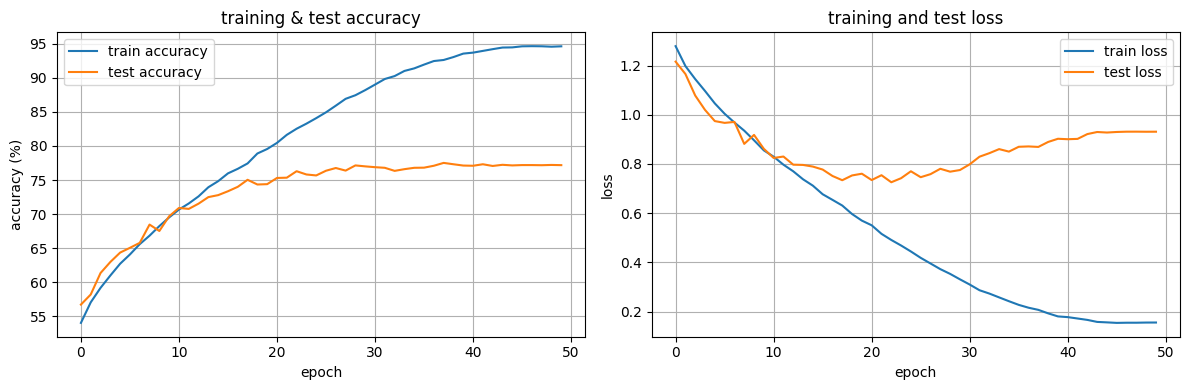

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.title('training & test accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['test_loss'], label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training and test loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_PATH, 'training_history.png'))
plt.show()